### Aggiunta Librerie

In [4]:
import datetime as datetime
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
start_date = datetime.datetime(1998, 11, 1)
end_date = datetime.datetime.now()

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

### Scraping dati

In [6]:
# Prendo i ticker che mi interessano

# leggo il file csv con i ticker
df = pd.read_csv("sp500_tickers.csv")
tickers_wanted = df["Ticker"].tolist()

# prendo solo i primi 5 tickers
tickers_wanted = tickers_wanted[:100]

tickers_wanted = ["AAPL", "MSFT", "AMZN", "JPM", "WMT"]

In [7]:
# Scarico i dati dei tickers

# Setta questa variabile a True se vuoi scaricare i dati anche se già presenti
force_download = False
tickers = []
for ticker in tickers_wanted:
    try:
        #controllo se il file già esiste e in caso lo salto
        if f"{ticker}.csv" in os.listdir("stocks") and not force_download:
            print(f"{ticker} già scaricato")
            tickers.append(ticker)
            continue
        data = yf.download(ticker, start=start_date_str, end=end_date_str, period="1d")
        data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
        if data.empty:
            print(f"{ticker} non ha dati")
            continue
        data.to_csv(f"stocks/{ticker}.csv")
        tickers.append(ticker)
    except Exception as e:
        print(f"Errore durante il download di {ticker}: {e}")


AAPL già scaricato
MSFT già scaricato
AMZN già scaricato
JPM già scaricato
WMT già scaricato


In [8]:
# Prendo i csv i li metto in una lista di dataframe
stocks = {}
for ticker in tickers:
    try:
        df = pd.read_csv(f"stocks/{ticker}.csv")
        stocks[ticker] = df
    except Exception as e:
        print(f"Errore durante la lettura di {ticker}: {e}")

## Tassi di rendimento

In [54]:
# Funzione per graficare i tassi di rendimento
def plot_ret_rate(df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df, label='Return')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Return", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim()
    plt.ylim(-0.2, 0.2)
    plt.legend()
    plt.tight_layout()

    # Mostra il grafico
    plt.show()

### Tassi di rendimenti logaritmici giornalieri

In [62]:
# calcolo i rendimenti logaritmici giornalieri per tutte le stocks a partire dai prezzi di chiusura e li metto in un' altra lista di dataframe
log_daily_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret[ticker] = np.log(p_t / p_t_1)
    ret.set_index("Date", inplace=True)
    log_daily_ret_rates = pd.concat([log_daily_ret_rates, ret[ticker]], axis=1)
    
print(log_daily_ret_rates)


                               AAPL      MSFT      AMZN       JPM       WMT
1998-11-03 00:00:00+00:00  0.004971 -0.005924 -0.038420 -0.004435 -0.028560
1998-11-04 00:00:00+00:00  0.022875  0.002966  0.029313  0.030637  0.017601
1998-11-05 00:00:00+00:00 -0.013007  0.008260 -0.010163  0.040132  0.031634
1998-11-06 00:00:00+00:00 -0.003279  0.027240 -0.031121  0.010299  0.016763
1998-11-09 00:00:00+00:00 -0.038499  0.012500  0.018395 -0.045057 -0.012324
...                             ...       ...       ...       ...       ...
2024-11-14 00:00:00+00:00  0.013677  0.003967 -0.012313  0.002940 -0.012120
2024-11-15 00:00:00+00:00 -0.014210 -0.028248 -0.042847  0.014122 -0.002608
2024-11-18 00:00:00+00:00  0.013333  0.001830 -0.004502 -0.001142 -0.002020
2024-11-19 00:00:00+00:00  0.001140  0.004871  0.014324 -0.007949  0.029531
2024-11-20 00:00:00+00:00  0.003149 -0.005520 -0.008491 -0.009548  0.006675

[6555 rows x 5 columns]


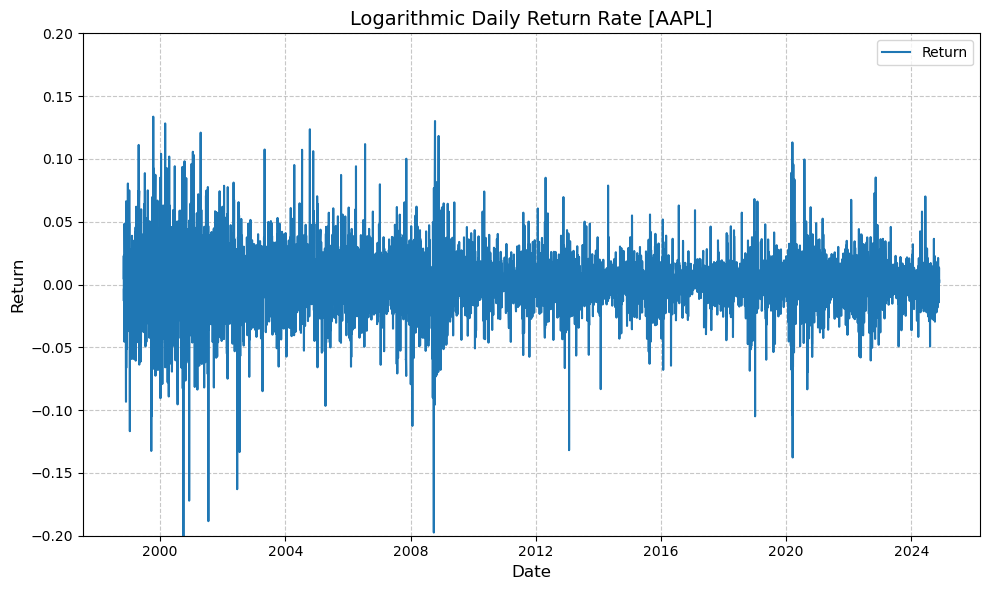

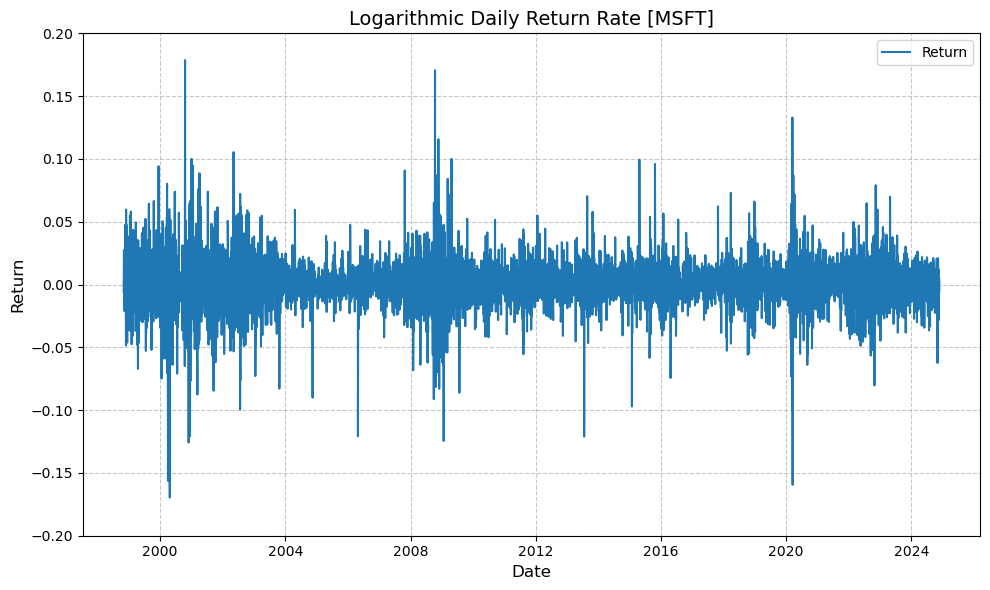

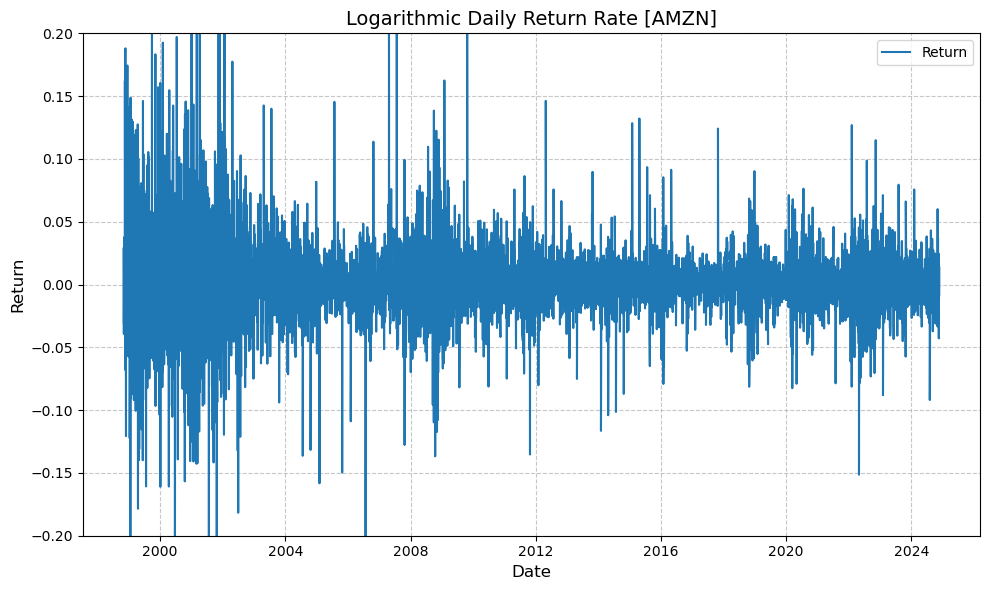

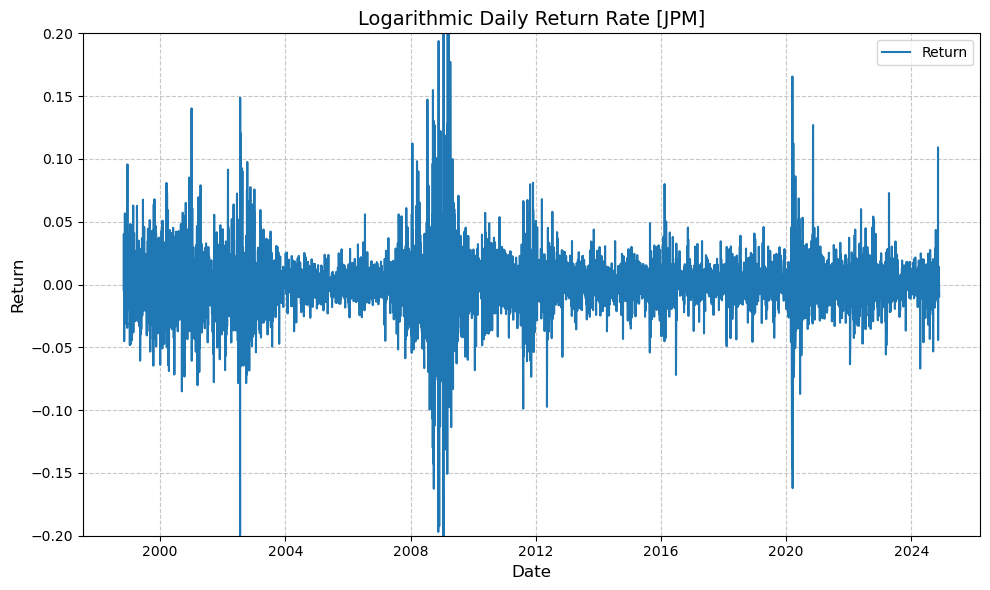

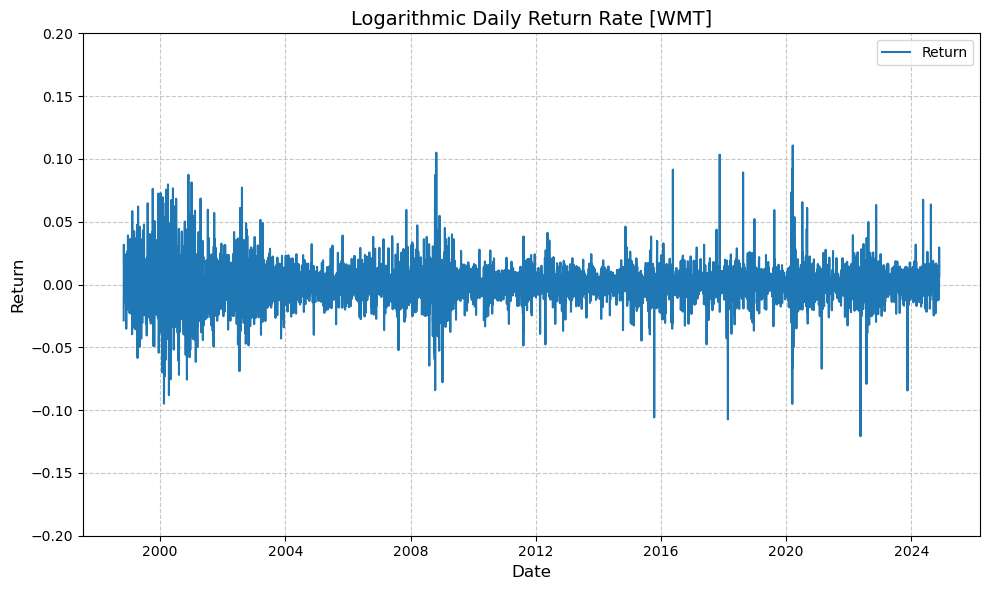

In [63]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker in tickers:
    plot_ret_rate(log_daily_ret_rates[ticker], "Logarithmic Daily Return Rate [" + ticker + "]")

### Tassi di rendimento settimanali

In [50]:
weekly_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Week"] = ret["Date"].dt.to_period("W")
    ret = ret.groupby("Week").first().reset_index()
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret[ticker] = (p_t - p_t_1)/p_t_1
    ret.set_index("Date", inplace=True)
    weekly_ret_rates = pd.concat([weekly_ret_rates, ret[ticker]], axis=1)
weekly_ret_rates.to_csv("weekly_ret_rates.csv")
print(weekly_ret_rates)

                         AAPL      MSFT      AMZN       JPM       WMT
1998-11-03 00:00:00  0.004983 -0.005907 -0.037691 -0.004425 -0.028156
1998-11-09 00:00:00  0.023139  0.002971  0.029747  0.031111  0.017757
1998-11-16 00:00:00 -0.012923  0.008294 -0.010111  0.040948  0.032140
1998-11-23 00:00:00 -0.003273  0.027615 -0.030642  0.010352  0.016904
1998-11-30 00:00:00 -0.037767  0.012579  0.018565 -0.044057 -0.012248
...                       ...       ...       ...       ...       ...
2024-10-21 00:00:00  0.006327 -0.006352 -0.006906 -0.006024 -0.006854
2024-10-28 00:00:00  0.032175  0.011187  0.025420  0.019636  0.012119
2024-11-04 00:00:00  0.000357 -0.004346  0.024322 -0.001902 -0.002162
2024-11-11 00:00:00 -0.031518 -0.010714 -0.011872 -0.000715 -0.005167
2024-11-18 00:00:00  0.002589  0.006017  0.033734  0.007390 -0.022449

[1360 rows x 5 columns]


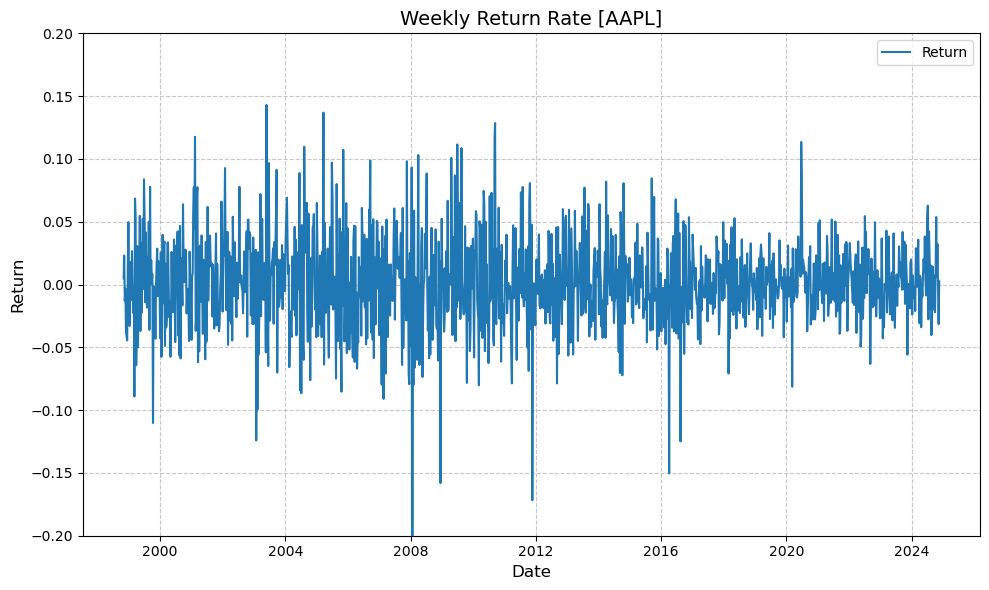

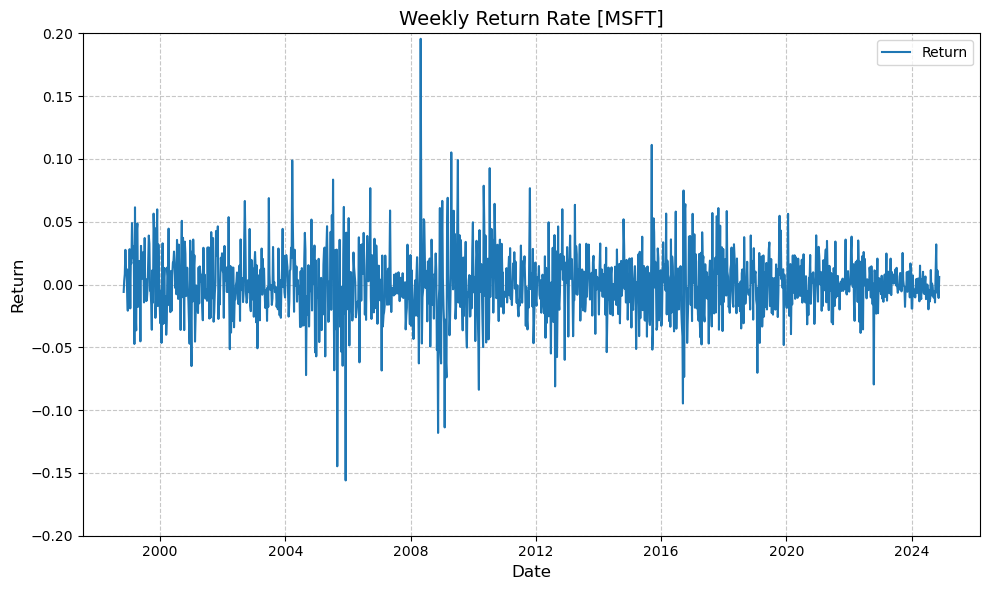

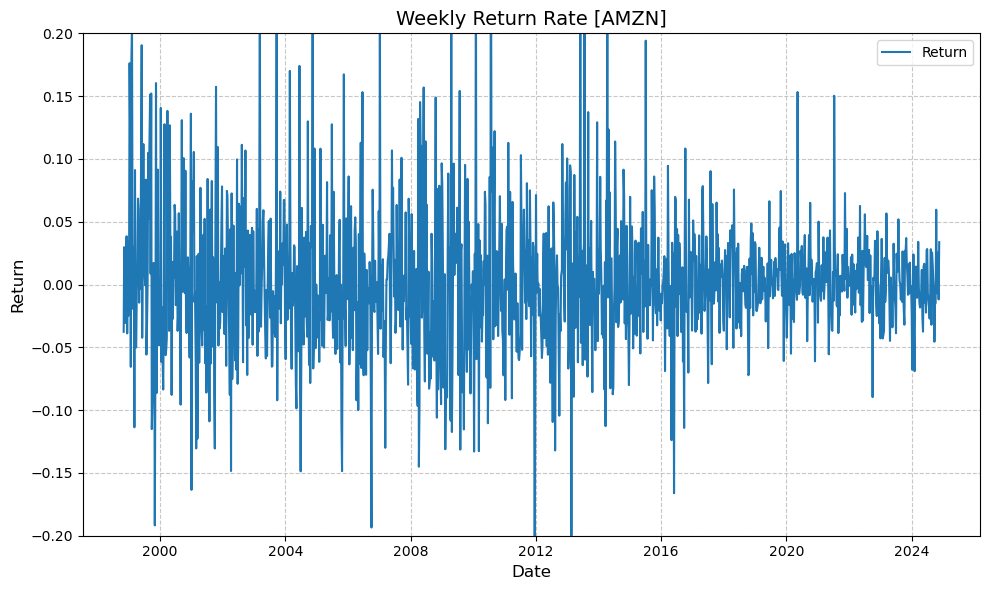

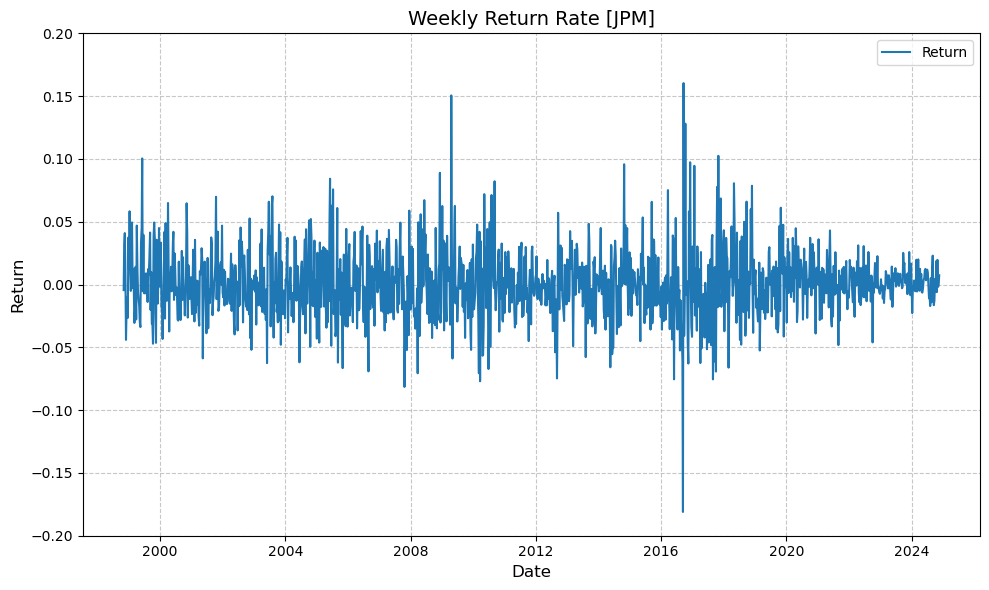

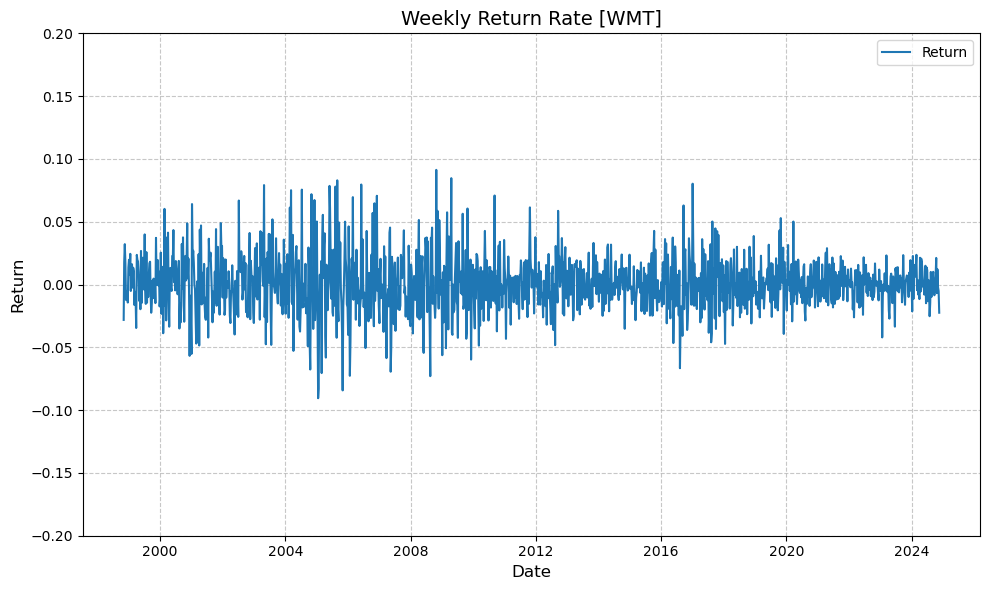

In [ ]:
# Faccio il grafico di tutti i ritorni per ogni stock
for ticker in tickers:
    plot_ret_rate(weekly_ret_rates[ticker], "Weekly Return Rate [" + ticker + "]")

### Tassi di rendimento mensili

In [64]:
monthly_ret_rates = pd.DataFrame()
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Month"] = ret["Date"].dt.to_period("M")
    ret = ret.groupby("Month").first().reset_index()
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret[ticker] = (p_t - p_t_1)/p_t_1
    ret.set_index("Date", inplace=True)
    monthly_ret_rates = pd.concat([monthly_ret_rates, ret[ticker]], axis=1)

print(monthly_ret_rates)

                         AAPL      MSFT      AMZN       JPM       WMT
1998-11-03 00:00:00  0.004983 -0.005907 -0.037691 -0.004425 -0.028156
1998-12-01 00:00:00  0.023139  0.002971  0.029747  0.031111  0.017757
1999-01-04 00:00:00 -0.012923  0.008294 -0.010111  0.040948  0.032140
1999-02-01 00:00:00 -0.003273  0.027615 -0.030642  0.010352  0.016904
1999-03-01 00:00:00 -0.037767  0.012579  0.018565 -0.044057 -0.012248
...                       ...       ...       ...       ...       ...
2024-07-01 00:00:00  0.056470  0.015432 -0.012478  0.022260  0.029474
2024-08-01 00:00:00 -0.018374 -0.033435 -0.064079  0.051089  0.013292
2024-09-03 00:00:00 -0.001702 -0.006289  0.032787  0.028685 -0.045409
2024-10-01 00:00:00 -0.076137 -0.005063 -0.078431 -0.049574 -0.067653
2024-11-01 00:00:00  0.020910 -0.003817  0.046606  0.052160 -0.006803

[313 rows x 5 columns]


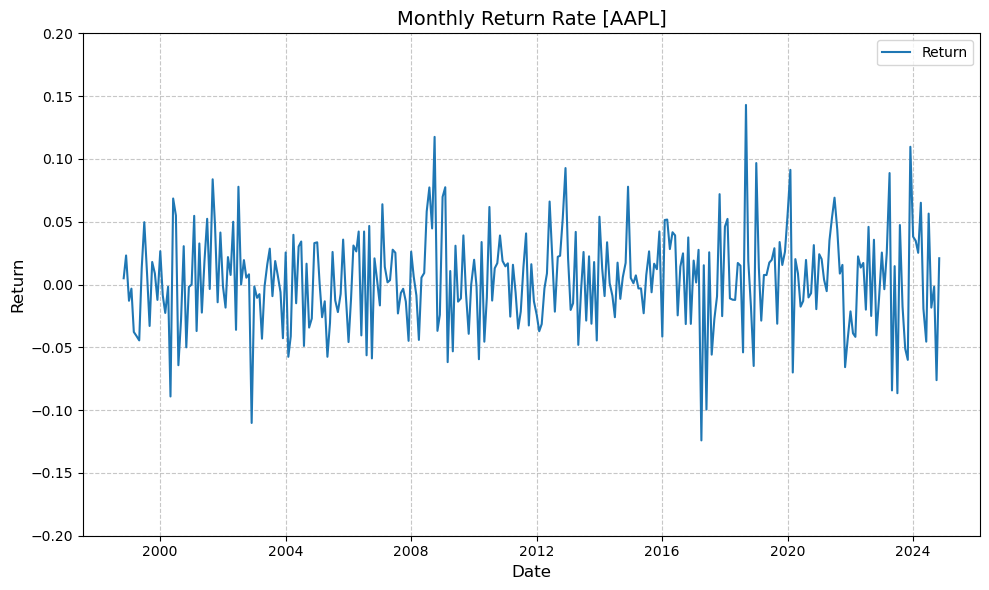

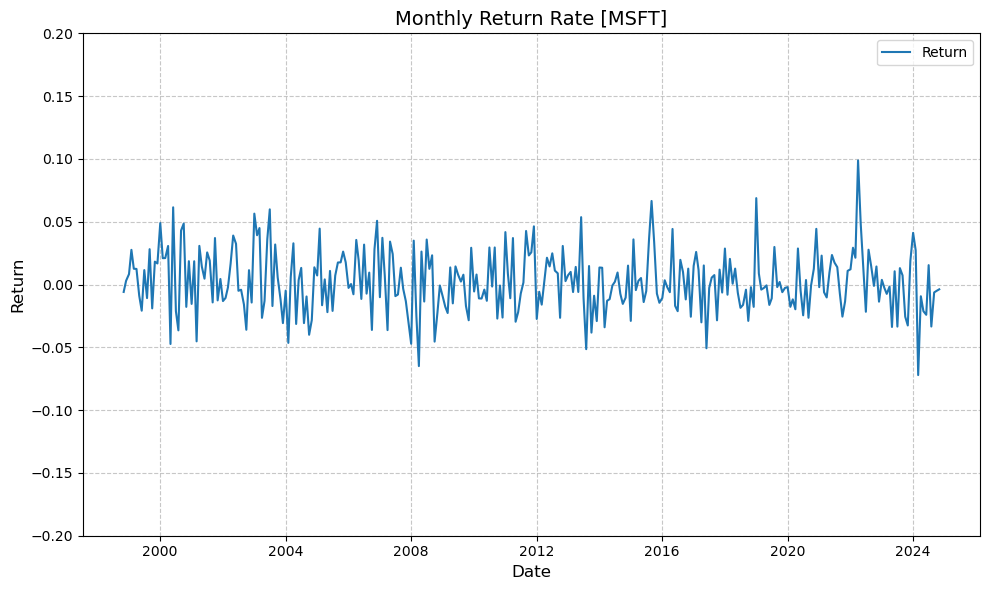

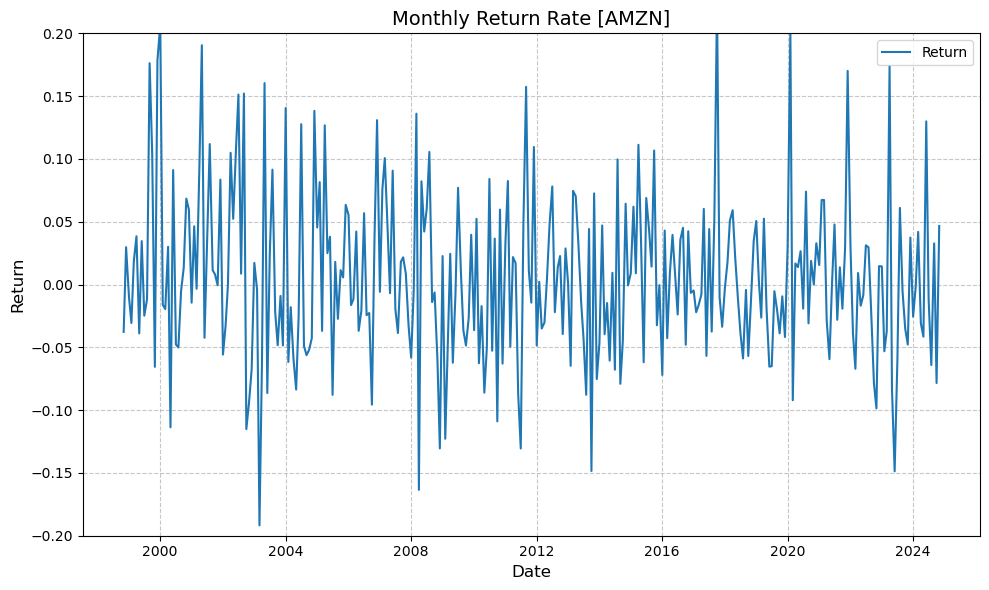

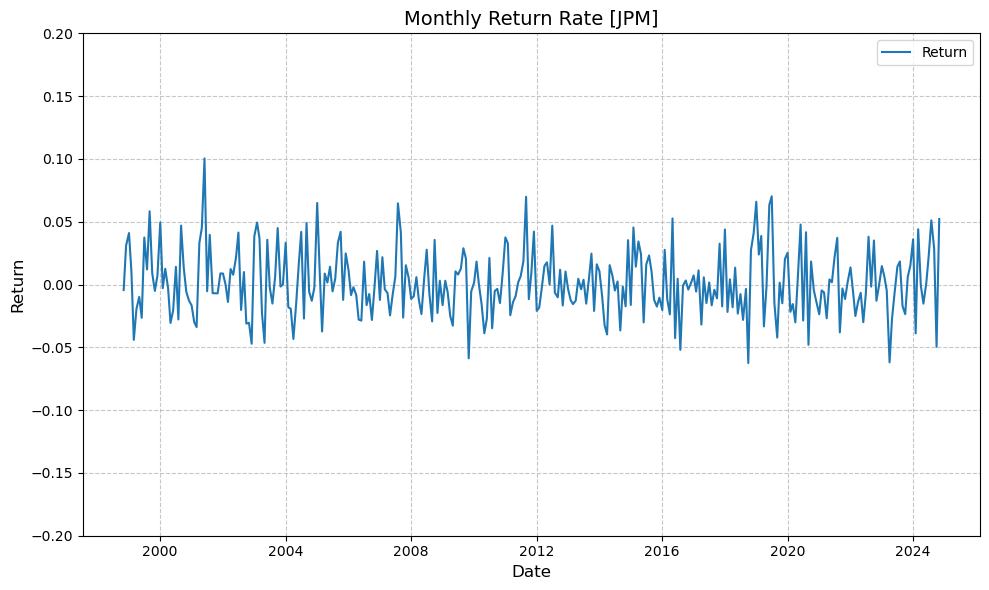

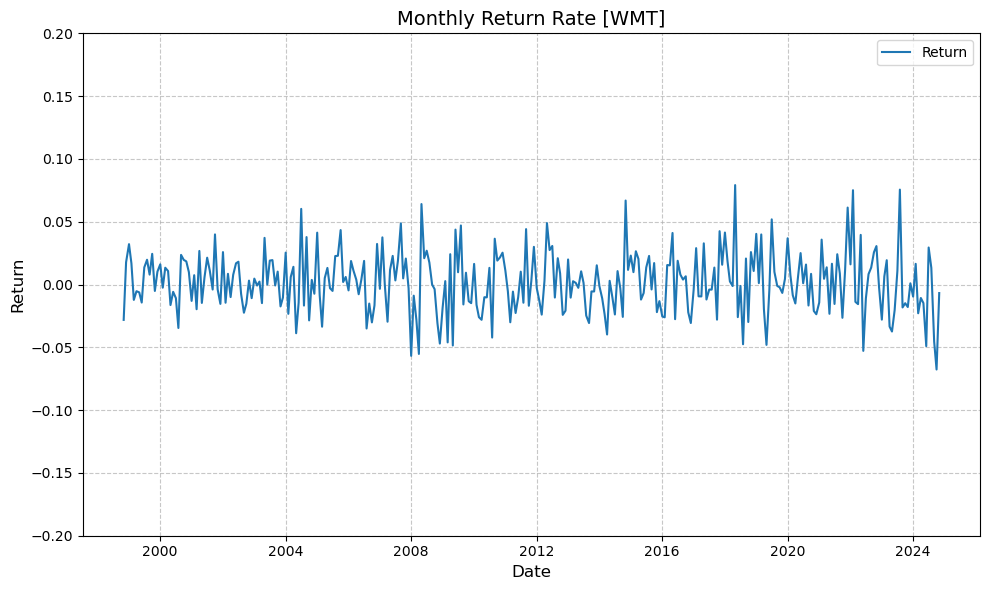

In [65]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in monthly_ret_rates.items():
    plot_ret_rate(ret, "Monthly Return Rate [" + ticker + "]")

## Frontiera efficiente

### Matrice Varianza-Covarianza

In [67]:
# Unisco i dati delle varie stock in un unico dataframe
all_stocks = pd.DataFrame()
for ticker, stock in stocks.items():
    df = pd.DataFrame()
    df = stock.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df = df.rename(columns={"Close": ticker})
    
    all_stocks = pd.concat([all_stocks, df[ticker]], axis=1)

print(all_stocks)

#Elimino tutte le righe che contengono NaN
all_stocks.dropna(inplace=True)

# Costruisco la matrice di covarianza
print(all_stocks.cov())

                                 AAPL        MSFT        AMZN         JPM  \
1998-11-02 00:00:00+00:00    0.335938   26.453125    1.091667   37.666668   
1998-11-03 00:00:00+00:00    0.337612   26.296875    1.050521   37.500000   
1998-11-04 00:00:00+00:00    0.345424   26.375000    1.081771   38.666668   
1998-11-05 00:00:00+00:00    0.340960   26.593750    1.070833   40.250000   
1998-11-06 00:00:00+00:00    0.339844   27.328125    1.038021   40.666668   
...                               ...         ...         ...         ...   
2024-11-14 00:00:00+00:00  228.220001  426.890015  211.479996  241.869995   
2024-11-15 00:00:00+00:00  225.000000  415.000000  202.610001  245.309998   
2024-11-18 00:00:00+00:00  228.020004  415.760010  201.699997  245.029999   
2024-11-19 00:00:00+00:00  228.279999  417.790009  204.610001  243.089996   
2024-11-20 00:00:00+00:00  229.000000  415.489990  202.880005  240.779999   

                                 WMT  
1998-11-02 00:00:00+00:00  11.468750

### Tassi di rendimento per le stock

In [68]:
# Calcolo del tasso di rendimento per ogni stock
stock_exp_daily_return = pd.DataFrame()
stock_exp_weekly_return = pd.DataFrame()
stock_exp_monthly_return = pd.DataFrame()
# Calcolo il tasso di rendimento medio
stock_exp_daily_return["Return"] = (np.log(all_stocks.iloc[-1]) - np.log(all_stocks.iloc[0])) / len(all_stocks)

# Calcolo il tasso di rendimento settimanale medio per ogni stock
stock_exp_weekly_return["Return"] = weekly_ret_rates.mean()

print(stock_exp_daily_return)

        Return
AAPL  0.000995
MSFT  0.000420
AMZN  0.000797
JPM   0.000283
WMT   0.000309


### Insieme dei portafogli fattibili

In [69]:
# Creo un dataframe in cui faccio variare la combinazione dei pesi delle azioni
wallets = pd.DataFrame()
# creo una colonna per ogni peso
for ticker in tickers:
    # faccio 100 estrazioni casuali tra 0 e 1
    #wallets[ticker] = np.random.uniform(-100, 100, 100000)
    wallets[ticker] = np.random.normal(0, 1000, 100000)

# Normalizzo i pesi
wallets = wallets.div(wallets.sum(axis=1), axis=0)

# Calcolo il rendimento atteso pesando i rendimenti delle azioni per i pesi
wallets_return = (wallets * stock_exp_daily_return["Return"]).sum(axis=1)

# Calcolo la varianza pesata
cov = all_stocks.cov()
print(cov)
wallets_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(cov, x))), axis=1)

# Unisco i dati in un unico dataframe
wallets["Return"] = wallets_return
wallets["Risk"] = wallets_variance
print(wallets)


             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3410.756097   6088.384486  3107.109234  2421.721956   753.740226
MSFT  6088.384486  11210.453982  5659.018961  4444.164801  1357.970156
AMZN  3107.109234   5659.018961  3192.273139  2389.867989   715.788729
JPM   2421.721956   4444.164801  2389.867989  1987.175396   564.210755
WMT    753.740226   1357.970156   715.788729   564.210755   179.434817
           AAPL      MSFT      AMZN       JPM       WMT    Return        Risk
0      0.593259 -0.378816  0.026107  0.527489  0.231961  0.000673   23.294627
1     -0.205329  0.246459 -0.069514  0.715398  0.312986  0.000143   45.885686
2     -2.317424  1.004554  2.867526 -0.762821  0.208165  0.000250  108.698492
3     -0.498600 -0.373764  1.090256  0.638735  0.143372  0.000441   32.248012
4      0.537459 -0.176295 -0.129004  0.343061  0.424780  0.000587   26.391600
...         ...       ...       ...       ...       ...       ...         ...
99995  0.308574  1.137337  0

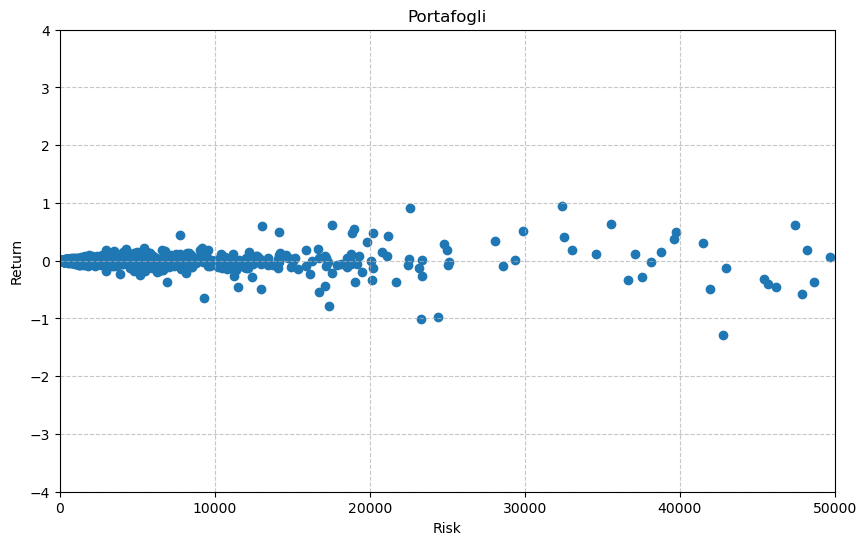

In [81]:
# Grafico i vari portafogli con uno scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(wallets["Risk"], wallets["Return"], alpha=1)
plt.title("Portafogli")
plt.xlabel("Risk")
plt.ylabel("Return")
plt.xlim(0, 0.5e5)
plt.ylim(-4, 4)

# mostro il grafico il scala logaritmica
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()